# FloPy McHenry Final Project 4/20

https://flopy.readthedocs.io/en/3.3.5/code.html

# Introduction
Flopy is a python package, developed to create and run MODFLOW groundwater flow models. The schematic below, illustrates how Flopy communicates with MODFLOW:

<img src="https://i.imgur.com/n2Dj6QF.png" title="Flopy to MODFLOW Flow Chart" /></a>

* <strong> <font size = 5> 1 </font> </strong> Aquifer properties are collected or estimated from some aquifer system, including dimensions, elevations, hydraulic conductivity, specific storage/yield and location/properties of wells, rivers, lakes or other hydrologic features. 

* <strong> <font size = 5> 2 </font> </strong> A model is created in a python script using the Flopy package to set up the different Packages MODFLOW uses to run its groundwater flow models, (DIS, BAS, LPF, RIV, WEL, ETC...), as python object. 

* <strong> <font size = 5> 3 </font> </strong> Flopy is called to write the MODFLOW input files from these objects. 

* <strong> <font size = 5> 4 </font> </strong> A Flopy function sends the files to a specified MODFLOW executable program that will be used to solve the groundwater flow model. 

* <strong> <font size = 5> 5 </font> </strong> The MODFLOW executable program outputs binary data into head and budget files. 

* <strong> <font size = 5> 6 </font> </strong> Flopy reads in binary head and budget data from the MODFLOW output files.

* <strong> <font size = 5> 7 </font> </strong> Data is visualized using Flopy's plotting capabilities.        


## Contents of script:

* <strong><a href="#I">I: Model Object</a></strong>


#### Creating MODFLOW Packages in Flopy:
* <strong><a href="#II">II: DIS Package</a> </strong> 
    <ul>
      <li> Discretizing time & space and setting up the MODFLOW DIS file.</li>  
        </ul>
    
* <strong><a href="#III">III: BAS Package</a> </strong>
    <ul>
      <li> Specifying cell activity and setting up the MODFLOW BAS file.</li>  
        </ul>
* <strong><a href="#IV">IV: LPF Package</a> </strong>
    <ul>
      <li> Defining model properties and setting up the MODFLOW LPF file.</li>  
        </ul>

* <strong><a href="#V">V: OC Package</a> </strong>
    <ul>
      <li> Specifying the data that the MODFLOW executable will record as output during the model run and setting up the MODFLOW OC package.</li>  
        </ul>

* <strong><a href="#VI">VI: PCG Package</a> </strong>
    <ul>
      <li> Assigning the pre-conditioned conjugate gradient solver to the groundwater flow model by setting up the MODFLOW PCG package.</li>  
        </ul>

#### Writing Files and Running Model:

* <strong><a href="#VII">VII: Write MODFLOW Input Files</a> </strong>
* <strong><a href="#VIII">VIII: Run MODFLOW executable</a> </strong>

#### Post Processing:
* <strong><a href="#IX">IX: Read MODFLOW output</a> </strong>
* <strong><a href="#X">X: Plot Results</a> </strong>
* <strong><a href="#XI">XI: Calibration</a> </strong>
* <strong><a href="#XII">XII: MT3DMS</a> </strong>
    </li>
<ol>



- First we will import the appropriate packages to run a modflow model in python and display the data

In [1]:
import flopy # if you get an error importing flopy, then install using: pip install flopy
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mp
import pandas as pd
import seaborn as sns
from scipy import stats
import scipy
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from simpledbf import Dbf5
import os
import matplotlib.mlab as mlab
import matplotlib.colors
import time

#jupyter specific--included to show plots in notebook
%config InlineBackend.figure_format = 'retina' 
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 10),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)
%matplotlib inline 

C:\Users\Owner\anaconda3\lib\site-packages\matplotlib_inline\config.py:75: DeprecationWarning: InlineBackend._figure_format_changed is deprecated in traitlets 4.1: use @observe and @unobserve instead.
  def _figure_format_changed(self, name, old, new):


 <a name="I"></a> 
 ## I. Create Model Object

- We define a Modflow model object using the following flopy function. The arguments are telling the 'model' what the modelname is and where the MODFLOW .exe file is to use to run the model on your computer. <strong> You will have to modify the exe_name variable to direct flopy to the modflow executable file on your computer!</strong> Note that the default model workspace is the location of your python notebook, so all MODFLOW files will be created there, but you may specify a different workspace if you'd like the files to be created somewhere else. (See: https://flopy.readthedocs.io/en/3.3.5/code.html for more options)

In [2]:
# don't forget to set this to your own local directory before starting

working_directory = 'C:/Users/Owner/Desktop/geog572/week9/FinalModelProject/'
os.chdir(working_directory)

In [3]:
modelname = "my_model"
m = flopy.modflow.Modflow(modelname, exe_name = 'mf2005')

In [4]:
# define the function that converts data frame to array; reshapes it and saves as variable
# 3D array of 10 layers by 205 rows by 225 columns
def array_shaper(j,layer):
    j = j.to_numpy()
    j = np.reshape(j, (205,225,layer))
    j = np.transpose(j, (2, 0, 1))
    return j

 <a name="II"></a> 
## II. MODFLOW DIS package
Now we attach the DIS package to our model. The DIS package specifies model discretization in space and time. It contains information regarding:
- <strong> spatial discretization: </strong> (the number of rows, layers, and columns, as well as cell sizes)
- <strong> temporal discretization: </strong> (number of stress periods, steady-state/transient model within a stress period, length of stress periods, and the number of time steps within stress periods)
- length and time <strong> units  </strong>

### Spatial Discretization
- We define a 100 x 100 unit model domain, and discretize this into 10 rows and columns. 

In [5]:
#assign discretization variables

nlay = 10
nrow = 205
ncol = 225
dx = 625.
dy = 625.
Lx = dx*ncol
Ly = dy*nrow
#dz = (ztop - zbot) / nlay

<img src="https://i.imgur.com/Abaeeyo.png" title="discretization" /></a>

<AxesSubplot:>

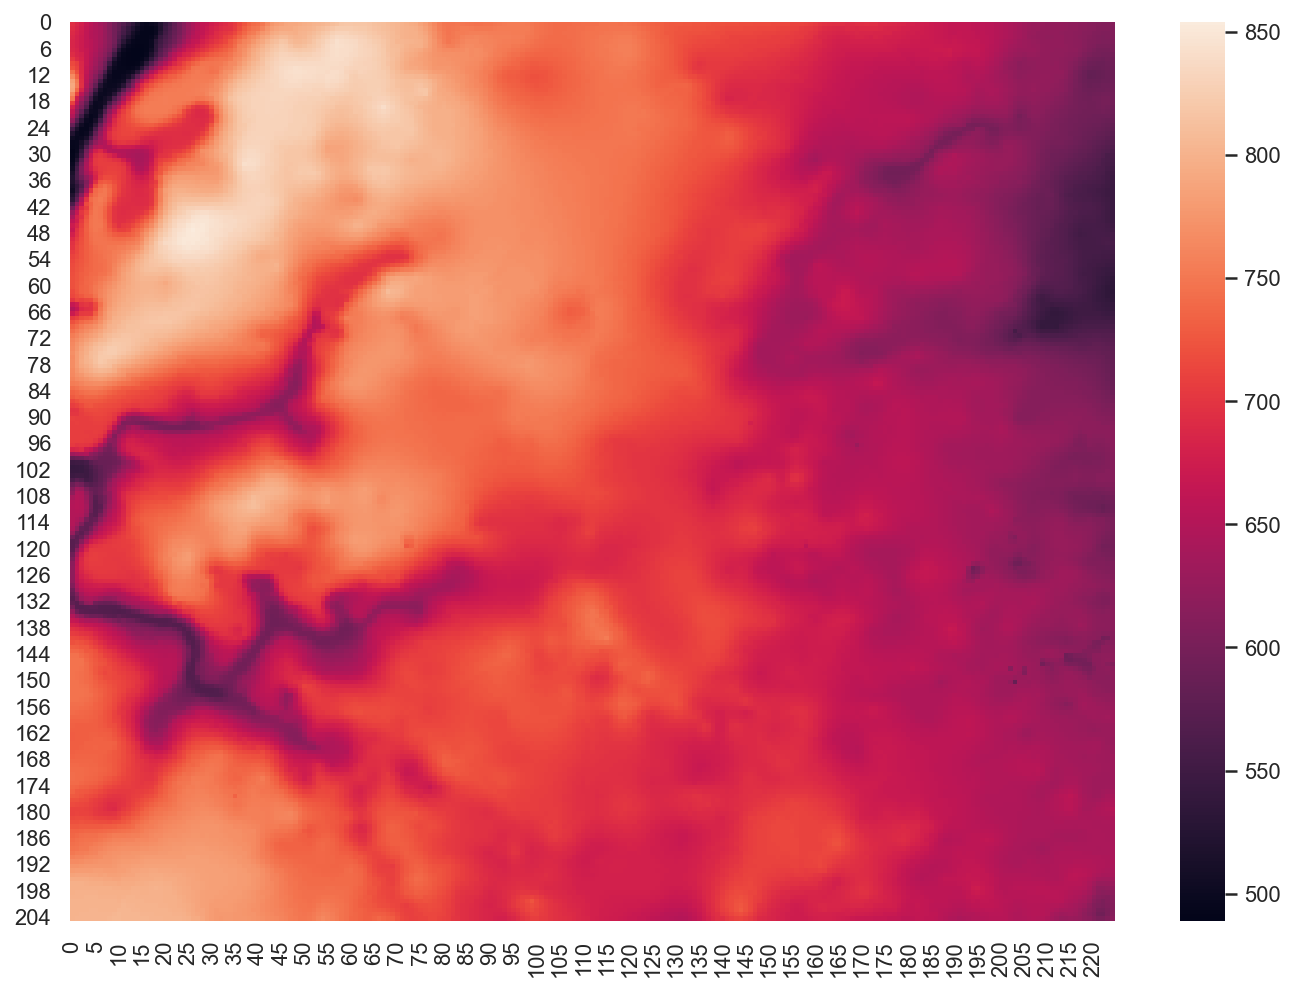

In [6]:
# set seaborn plotting for nice and big figures
sns.set(rc={'figure.figsize':(11.7,8.27),"font.size":20,"axes.titlesize":20}, style = 'white')

# load in top and bottom elevations for model
top_raw = pd.read_csv('top_elevation.csv')
ztop = array_shaper(top_raw,1)
bottoms_raw = pd.read_csv('bottom_elevations.csv')
zbot = array_shaper(bottoms_raw,10)
sns.heatmap(zbot[9,:,:], cmap = 'rocket')

### Temporal Discretization

To discretize time, we must first specify how many stress periods are involved in this model. This is done through flopy's variable 'nper'. As we are solving a steady-state model, we will only specify 1 stress period.

In [7]:
#specify number of stress periods
nper = 1

We then create a variable called "steady" as a list of boolean "True/False" flags, one for each stress period, indicating whether the finite difference solver should solve a steady-state or transient model. True=steady-state, False=Transient. Our list will only contain one boolean for the single, steady-state stress period.

In [8]:
#specify if stress period is transient or steady-state
steady = [True]

print("steady-state data: \n", steady)

steady-state data: 
 [True]


There are several other variables involved in the DIS package that allow the user to specify time-step properties of the stress period data (legnth of stress period, number of time steps per stress period, and time step multiplier). As this model is a single period, steady-state model, these options don't apply and hence we will not specify them.

### Create DIS object

The spatial and temporal discretizations are used to create the flopy dis object which will later be used to create the MODFLOW "dis" package. 

In [9]:
#create flopy discretization object, length and time are meters (2) and days (4)
dis = flopy.modflow.ModflowDis(model=m, nlay=nlay, nrow=nrow, ncol=ncol, 
                               delr=dx, delc=dy, top=ztop, botm=zbot, 
                               itmuni = 4, lenuni = 2, 
                               nper=nper, steady=steady)

In [10]:
type(dis)

flopy.modflow.mfdis.ModflowDis

In [11]:
m.dis.nlay

10

Confused about the arguments given to the flopy.modflow.ModflowDis() class assignment? 
Check out the Flopy documentation here: http://modflowpy.github.io/flopydoc/mfdis.html 

If you'd like to see the grid you've created, flopy has plotting capabilities to visualize "ModelMap" attributes such as the grid, which it pulls from the flopy "dis" class instance. Note that ModelMap uses matplotlib, so you will want to make sure you have that package imported at the top of your script as well!

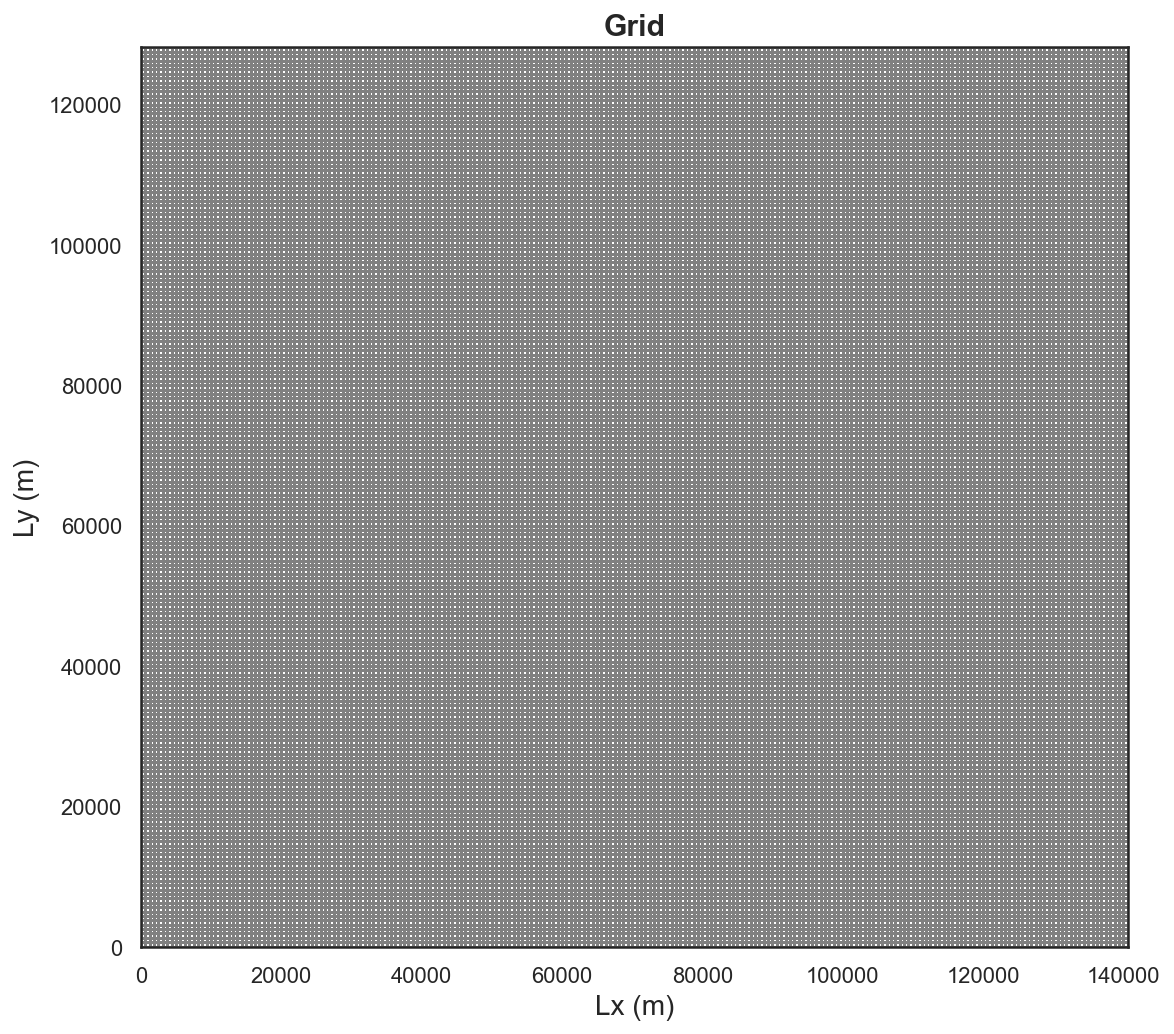

In [12]:
#use flopy to plot the grid of model 'm'
modelmap = flopy.plot.map.PlotMapView(model=m, layer=0)
grid = modelmap.plot_grid() 
plt.xlabel('Lx (m)',fontsize = 14)
plt.ylabel('Ly (m)',fontsize = 14)
plt.title('Grid', fontsize = 15, fontweight = 'bold')
plt.show()

 <a name="III"></a> 
## III. MODFLOW BAS package

Next, we attach the BAS package to our model. The BAS package specifies cell activity (how cells will participate in the model run) as well as starting heads to be used in the cells at the start of the groundwater flow simulation.

### Define Cell Activity: IBOUND

We assign the cell activity using a variable called <strong>IBOUND</strong>. Ibound is defined as an array of integers of form (nlay, nrow, ncol), or one for each cell with flags for the activity level:

- <strong> >/= 1: active </strong> (cell has active finite difference equations calculating the head for this cell as well as flows between its neighbors) 
- <strong> = 0: inactive </strong> (cell has no active finite difference equations associated with it)
- <strong> </= -1: constant head </strong>  (cell has active finite difference equation for flows between cells but not for head at the cell as it is kept constant throughout the simulation)

For this model, the first and last column are set to be constant heads and the rest of the domain is set as active. 

In [13]:
#create ibound as array of ints = 1
ibound = np.ones((nlay, nrow, ncol), dtype=np.int32)


print("ibound values: \n", ibound)

ibound values: 
 [[[1 1 1 ... 1 1 1]
  [1 1 1 ... 1 1 1]
  [1 1 1 ... 1 1 1]
  ...
  [1 1 1 ... 1 1 1]
  [1 1 1 ... 1 1 1]
  [1 1 1 ... 1 1 1]]

 [[1 1 1 ... 1 1 1]
  [1 1 1 ... 1 1 1]
  [1 1 1 ... 1 1 1]
  ...
  [1 1 1 ... 1 1 1]
  [1 1 1 ... 1 1 1]
  [1 1 1 ... 1 1 1]]

 [[1 1 1 ... 1 1 1]
  [1 1 1 ... 1 1 1]
  [1 1 1 ... 1 1 1]
  ...
  [1 1 1 ... 1 1 1]
  [1 1 1 ... 1 1 1]
  [1 1 1 ... 1 1 1]]

 ...

 [[1 1 1 ... 1 1 1]
  [1 1 1 ... 1 1 1]
  [1 1 1 ... 1 1 1]
  ...
  [1 1 1 ... 1 1 1]
  [1 1 1 ... 1 1 1]
  [1 1 1 ... 1 1 1]]

 [[1 1 1 ... 1 1 1]
  [1 1 1 ... 1 1 1]
  [1 1 1 ... 1 1 1]
  ...
  [1 1 1 ... 1 1 1]
  [1 1 1 ... 1 1 1]
  [1 1 1 ... 1 1 1]]

 [[1 1 1 ... 1 1 1]
  [1 1 1 ... 1 1 1]
  [1 1 1 ... 1 1 1]
  ...
  [1 1 1 ... 1 1 1]
  [1 1 1 ... 1 1 1]
  [1 1 1 ... 1 1 1]]]


### Define Starting Heads

Values for starting heads are given cell by cell with the variable <strong>strt</strong> defined as an array of floats of form (nlay, nrow, ncol). For this model the left and right boundaries are set to be constant heads in the IBOUND variable, so the starting heads assigned to these cells will be set throughout the model. Since we are interested in steady-state flow from a left boundary of h=10m and right boundary of h=0m we assign those conditions in the strt variable.

In [14]:
#create strt as array of floats = 1
strt = [ztop,ztop,ztop,ztop,ztop,ztop,ztop,ztop,ztop,ztop]

#np.ones((nlay, nrow, ncol), dtype=np.float32)
#set left side head to 10 m
#strt[:, :, 0] = 10.
#set right side head to 0 m
#strt[:, :, -1] = 0.

print("starting head values: \n", strt)

starting head values: 
 [array([[[980, 968, 978, ..., 866, 838, 854],
        [976, 967, 977, ..., 907, 898, 936],
        [973, 964, 967, ..., 921, 901, 903],
        ...,
        [844, 847, 856, ..., 784, 792, 821],
        [852, 854, 859, ..., 776, 782, 837],
        [853, 854, 857, ..., 783, 809, 840]]], dtype=int64), array([[[980, 968, 978, ..., 866, 838, 854],
        [976, 967, 977, ..., 907, 898, 936],
        [973, 964, 967, ..., 921, 901, 903],
        ...,
        [844, 847, 856, ..., 784, 792, 821],
        [852, 854, 859, ..., 776, 782, 837],
        [853, 854, 857, ..., 783, 809, 840]]], dtype=int64), array([[[980, 968, 978, ..., 866, 838, 854],
        [976, 967, 977, ..., 907, 898, 936],
        [973, 964, 967, ..., 921, 901, 903],
        ...,
        [844, 847, 856, ..., 784, 792, 821],
        [852, 854, 859, ..., 776, 782, 837],
        [853, 854, 857, ..., 783, 809, 840]]], dtype=int64), array([[[980, 968, 978, ..., 866, 838, 854],
        [976, 967, 977, ..., 907,

### Create BAS class

We now use <strong>strt</strong> and <strong>IBOUND</strong> to make the 'bas' flopy class instance which will later be used to create the MODFLOW BAS package.

In [15]:
#create flopy bas class
bas = flopy.modflow.ModflowBas(m, ibound=ibound, strt=strt)

### Create RIV object

Creating a MODFLOW river package.

In [16]:
rivs = pd.read_csv('rivers.csv')
rivs = rivs[['layer','row','column','Stage','Conductanc','Bottom']]
rivs['layer'] = rivs['layer']-1
rivs['row'] = rivs['row']-1
rivs['column'] = rivs['column']-1
rivs = rivs.to_numpy()
rivs = {0: rivs}
print(rivs)

{0: array([[    0.  ,    31.  ,   223.  ,   742.56, 17426.6 ,   739.56],
       [    0.  ,    30.  ,   223.  ,   742.56, 26564.84,   739.56],
       [    0.  ,    29.  ,   223.  ,   742.56, 28924.62,   739.56],
       ...,
       [    0.  ,   204.  ,   184.  ,   725.12, 11021.6 ,   724.12],
       [    0.  ,   194.  ,   184.  ,   725.12,  7127.32,   724.12],
       [    0.  ,   204.  ,   185.  ,   725.94,   622.98,   724.94]])}


In [17]:
riv = flopy.modflow.ModflowRiv(m, ipakcb=None, stress_period_data=rivs, dtype=None, extension='riv', options=None, unitnumber=None, filenames=None)

 <a name="IV"></a> 
## IV. MODFLOW LPF package

The LPF package specifies Layer Properties associated with the flow in each cell. It holds information regarding horizontal and vertical hydraulic conductivity, layer confinement properties (confined/unconfined), specific storage, and specific yield among other flags for the model run for  which we will use flopy's default settings.

### Define Hydraulic Conductivity

Here we define "hk" as a variable for horizontal hydraulic conductivity of 1 m/d that will be the same in the x and y directions, and "vka" as a variable for vertical conductivity of 1 m/d. hk and vka are arrays of floats of form (nlay, nrow, ncol) with conductivity values for each cell. You may also a ratio of anisotropy in the y direction for the flopy LPF function, if hk should be anisotropic in the xy plane. http://modflowpy.github.io/flopydoc/mflpf.html has details regarding these options.


In [18]:
# read in dbf to pandas dataframe
file = 'hydraulic_conductivity.dbf'
dbf = Dbf5(file)
df = dbf.to_dataframe()
df.head()

,row,column,node,Zone1,Kx1,Ky1,Kz1,Zone2,Kx2,Ky2,...,Ky8,Kz8,Zone9,Kx9,Ky9,Kz9,Zone10,Kx10,Ky10,Kz10
0,1,1,0,73,2.52832,2.52832,0.043545,73,2.52832,2.52832,...,2.52832,0.043545,23,1.3507,1.3507,0.043406,23,1.3507,1.3507,0.043406
1,1,2,0,73,2.52832,2.52832,0.043545,73,2.52832,2.52832,...,2.52832,0.043545,23,1.3507,1.3507,0.043406,23,1.3507,1.3507,0.043406
2,1,3,0,73,2.52832,2.52832,0.043545,73,2.52832,2.52832,...,2.52832,0.043545,23,1.3507,1.3507,0.043406,23,1.3507,1.3507,0.043406
3,1,4,0,73,2.52832,2.52832,0.043545,73,2.52832,2.52832,...,2.52832,0.043545,23,1.3507,1.3507,0.043406,23,1.3507,1.3507,0.043406
4,1,5,0,73,2.52832,2.52832,0.043545,73,2.52832,2.52832,...,2.52832,0.043545,23,1.3507,1.3507,0.043406,23,1.3507,1.3507,0.043406


In [19]:
# create dataframes of the 10 zones, Kx, Ky, and Kz

zone = df[df.columns[pd.Series(df.columns).str.contains("Z")]]
x = df[df.columns[pd.Series(df.columns).str.contains("x")]]
y = df[df.columns[pd.Series(df.columns).str.contains("y")]]
z = df[df.columns[pd.Series(df.columns).str.contains("z")]]

zone

,Zone1,Zone2,Zone3,Zone4,Zone5,Zone6,Zone7,Zone8,Zone9,Zone10
0,73,73,73,73,73,73,73,73,23,23
1,73,73,73,73,73,73,74,73,23,23
2,73,73,73,73,73,73,74,73,23,23
3,73,73,73,73,73,73,74,73,23,23
4,73,73,73,73,73,73,74,73,23,23
...,...,...,...,...,...,...,...,...,...,...
46120,74,74,73,74,74,74,74,74,74,15
46121,74,74,73,74,74,74,74,74,74,15
46122,74,74,73,74,74,74,74,74,74,15
46123,74,74,73,74,74,74,74,74,74,15


In [20]:
# save function output to variables
x_reshaped = array_shaper(x,10)
z_reshaped = array_shaper(z,10)

In [21]:
# check shape

print(x_reshaped.shape)
print(z_reshaped.shape)

(10, 205, 225)
(10, 205, 225)


<AxesSubplot:>

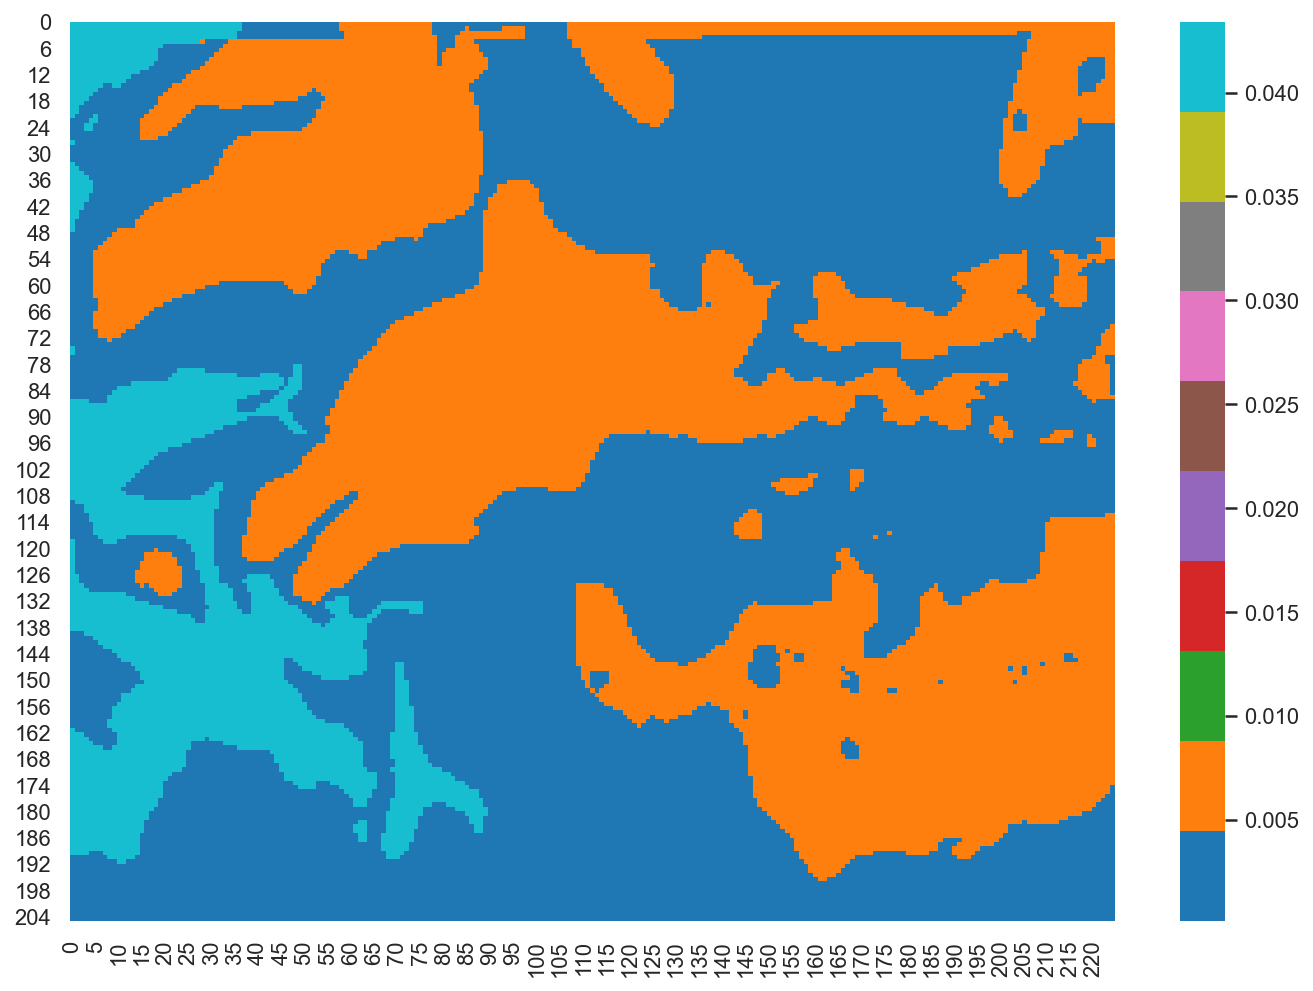

In [22]:
x = z_reshaped[9,:,:]
sns.heatmap(x, cmap = 'tab10')

### Define Specific Storage

Specific storage is defined in a similar format to hydraulic conductivity with a value of $1 x 10^{-5} m^{-1}$ for each cell.

In [23]:
#define specific storage
ss = np.ones((nlay,nrow,ncol), dtype=np.float)
ss[:,:,:] = 1e-5

print("specific storage values: \n", ss)

specific storage values: 
 [[[1.e-05 1.e-05 1.e-05 ... 1.e-05 1.e-05 1.e-05]
  [1.e-05 1.e-05 1.e-05 ... 1.e-05 1.e-05 1.e-05]
  [1.e-05 1.e-05 1.e-05 ... 1.e-05 1.e-05 1.e-05]
  ...
  [1.e-05 1.e-05 1.e-05 ... 1.e-05 1.e-05 1.e-05]
  [1.e-05 1.e-05 1.e-05 ... 1.e-05 1.e-05 1.e-05]
  [1.e-05 1.e-05 1.e-05 ... 1.e-05 1.e-05 1.e-05]]

 [[1.e-05 1.e-05 1.e-05 ... 1.e-05 1.e-05 1.e-05]
  [1.e-05 1.e-05 1.e-05 ... 1.e-05 1.e-05 1.e-05]
  [1.e-05 1.e-05 1.e-05 ... 1.e-05 1.e-05 1.e-05]
  ...
  [1.e-05 1.e-05 1.e-05 ... 1.e-05 1.e-05 1.e-05]
  [1.e-05 1.e-05 1.e-05 ... 1.e-05 1.e-05 1.e-05]
  [1.e-05 1.e-05 1.e-05 ... 1.e-05 1.e-05 1.e-05]]

 [[1.e-05 1.e-05 1.e-05 ... 1.e-05 1.e-05 1.e-05]
  [1.e-05 1.e-05 1.e-05 ... 1.e-05 1.e-05 1.e-05]
  [1.e-05 1.e-05 1.e-05 ... 1.e-05 1.e-05 1.e-05]
  ...
  [1.e-05 1.e-05 1.e-05 ... 1.e-05 1.e-05 1.e-05]
  [1.e-05 1.e-05 1.e-05 ... 1.e-05 1.e-05 1.e-05]
  [1.e-05 1.e-05 1.e-05 ... 1.e-05 1.e-05 1.e-05]]

 ...

 [[1.e-05 1.e-05 1.e-05 ... 1.e-05 1.e-05 1

C:\Users\Owner\AppData\Local\Temp/ipykernel_2224/3281996141.py:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ss = np.ones((nlay,nrow,ncol), dtype=np.float)


### Define Aquifer Confinement Properties

Layers may be specified in flopy with variable <strong> laytyp </strong>, an array of (nlay) integer flags to say whether a model is:

- <strong> =0 Confined:</strong>  Aquifer layers will be treated as confined
- <strong> >0 Convertible:</strong> Aquifer layers will be treated as confined if the water level is above the top of the aquifer cell and unconfined if the water level is below the top of the aquifer cell.

This single-layer model will be treated as confined.

In [24]:
#define layer type as confined
laytyp = np.zeros((nlay,), dtype=np.int32)

print("layer type values: \n", laytyp)

layer type values: 
 [0 0 0 0 0 0 0 0 0 0]


### Define LPF object
We now use <strong>hk</strong>, <strong>vk</strong>,  <strong>ss</strong>, and <strong>laytyp</strong> to make the 'lpf' flopy object which will be used to create the MODFLOW LPF package. <strong>ipakcb</strong> is a flag to say whether we will save cell by cell buget data (flows etc) (ipakcb>0 = save data). (<strong>Note:</strong> Flopy claims that budget data saves by using the ipakcb default settings, but it seems that ipakcb must be explicitly specified in order to be saved.)

In [25]:
lpf = flopy.modflow.ModflowLpf(model=m, hk=x_reshaped, vka=.5*z_reshaped, ss=ss, laytyp=laytyp, ipakcb=1)

### Create DRN class

In [26]:
ztop2 = ztop[0,:,:]

In [27]:

drains = []
for index, value in np.ndenumerate(x_reshaped[0,:,:]):
    if value<20:
        drains.append([0,index[0],index[1],ztop2[index],5000])
    
drns = {0: drains}


In [28]:
drn = flopy.modflow.ModflowDrn(m, ipakcb=None, stress_period_data=drns, dtype=None, extension='drn', options=None, unitnumber=None, filenames=None)

If you wish to visualize the ibound variable assigned to this bas package, flopy ModelMap may be also used to display ibound. 

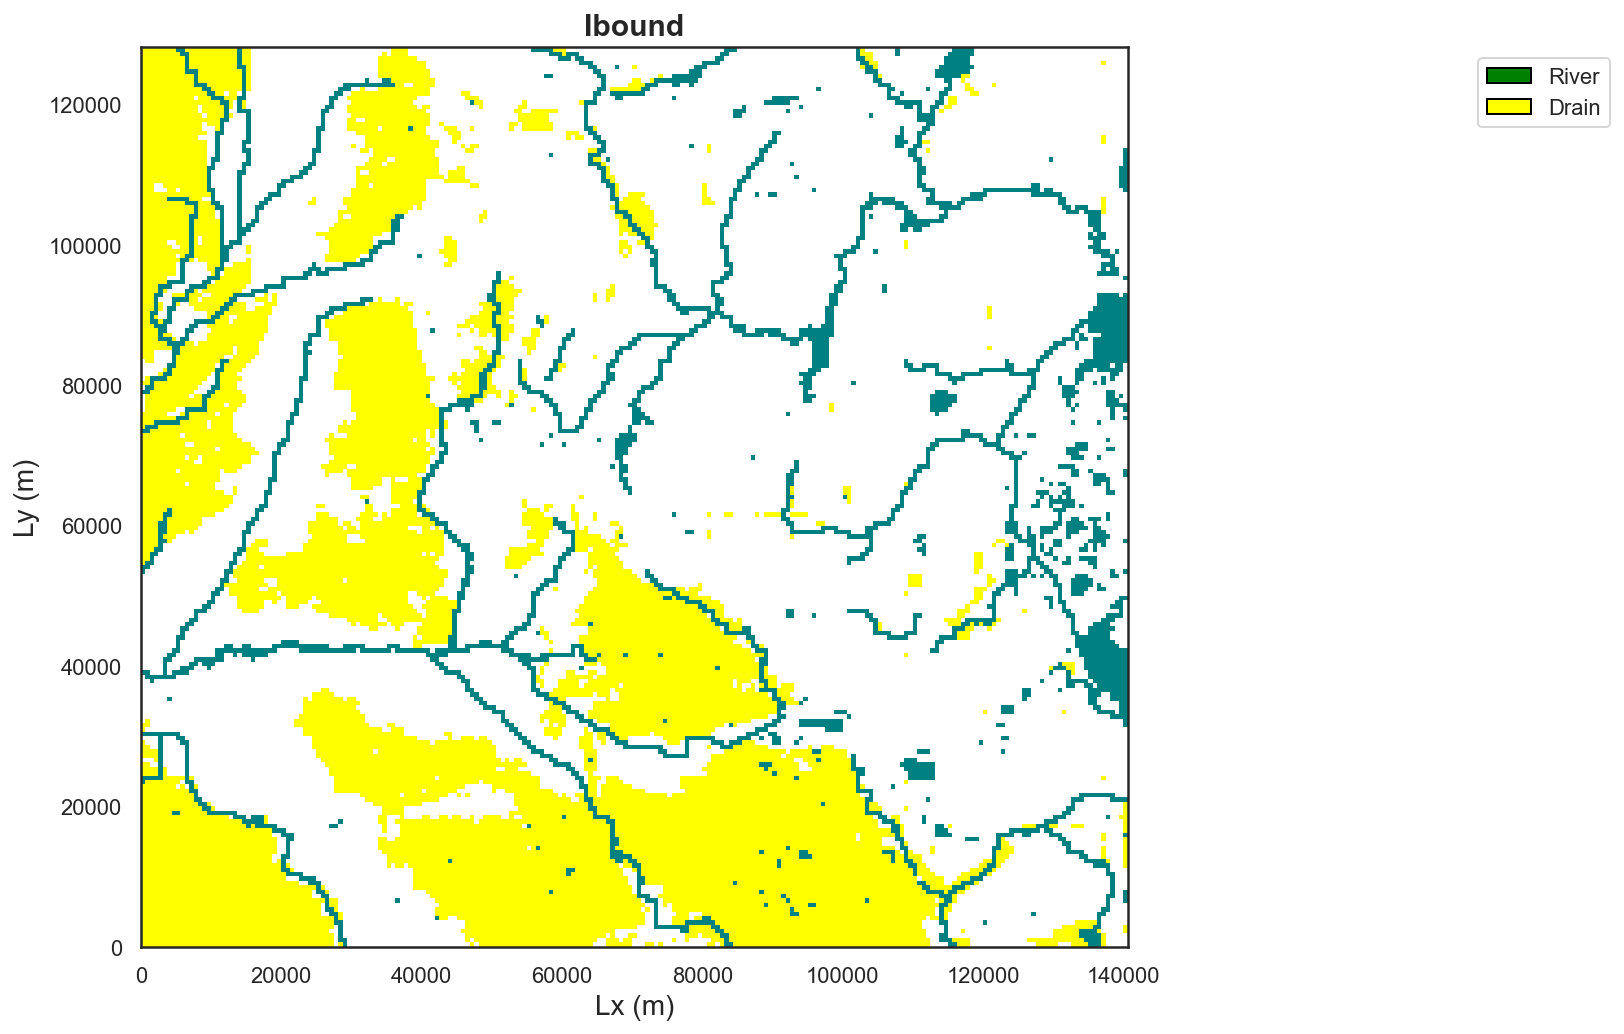

In [29]:
#plot grid and ibound
modelmap = flopy.plot.PlotMapView(model=m, layer=0)
#grid = modelmap.plot_grid()
drn_plot = modelmap.plot_bc(ftype='DRN')
riv_plot = modelmap.plot_bc(ftype='RIV')
#ib = modelmap.plot_ibound()
#add labels and legend
plt.xlabel('Lx (m)',fontsize = 14)
plt.ylabel('Ly (m)',fontsize = 14)
plt.title('Ibound', fontsize = 15, fontweight = 'bold')
plt.legend(handles=[mp.patches.Patch(color='green',label='River',ec='black'),
                    mp.patches.Patch(color='yellow',label='Drain',ec='black')],
                   bbox_to_anchor=(1.5,1.0))
plt.show(modelmap)

### Recharge

In [30]:
recharge = 0*x_reshaped[0,:,:]
for index, value in np.ndenumerate(x_reshaped[0,:,:]):
    if value<20:
        recharge[index] = 0.0005 # ft/day
    else:
        recharge[index] = 0.001 # ft/day
        
    
recharge = {0: recharge}

In [31]:
rch = flopy.modflow.ModflowRch(m,nrchop=3,ipakcb=None,rech=recharge,irch=0,extension='rch')

## V. MODFLOW WELL Package



In [32]:
# Below ids the setup for well stress period 59

Well_stress = pd.read_csv('newminwelldata.csv')
Well_stress=Well_stress[['Layer', 'row', 'col', 'flux']]
Well_stress = Well_stress[Well_stress.flux <-500]
print (Well_stress)

# Daniel, I think in your video you used the next 4 lines to remove column names before coverting to dictionary. 
# In this code they add -1s to dataframe, but wells plot and it runs (where we were last time).

# Well_stress['Layer']=Well_stress['Layer']-1
Well_stress['row']=Well_stress['row']-1
Well_stress['col']=Well_stress['col']-1
# Well_stress['flux']=Well_stress['flux']-1

Well_stress=Well_stress.to_numpy()
Well_stress = {0: Well_stress}
print(Well_stress)

# This seems to create dictionary without indeces, but does not run through well plotting routine.

# Any suggestions?

     Layer  row  col   flux
9        0   89   35  -8816
10       0   95   35  -1924
11       0   95   36  -5771
23       0   45   48 -31722
24       0   45   48 -16284
..     ...  ...  ...    ...
298      0   94  221  -5916
299      0   94  221  -5916
302      0   36  222  -3791
314      0   40  225 -20872
315      0  102  225 -10045

[108 rows x 4 columns]
{0: array([[      0,      88,      34,   -8816],
       [      0,      94,      34,   -1924],
       [      0,      94,      35,   -5771],
       [      0,      44,      47,  -31722],
       [      0,      44,      47,  -16284],
       [      0,     145,      50,  -49609],
       [      0,     145,      53,  -28069],
       [      0,     143,      54,  -22495],
       [      0,     181,      75,    -791],
       [      0,     146,      75, -112242],
       [      0,     146,      75, -112242],
       [      0,     146,      83,  -43486],
       [      0,     146,      87,  -53236],
       [      0,     146,      87,   -1692],
      

In [33]:
# Create flopy wel class 
# ModflowWel(model, ipakcb=None, stress_period_data=None, dtype=None, extension='wel', options=None, binary=False, unitnumber=None, filenames=None, add_package=True)

wel = flopy.modflow.ModflowWel(m, ipakcb=None, stress_period_data=Well_stress, dtype=None, extension='wel', options=None, binary=False, unitnumber=None, filenames=None,)

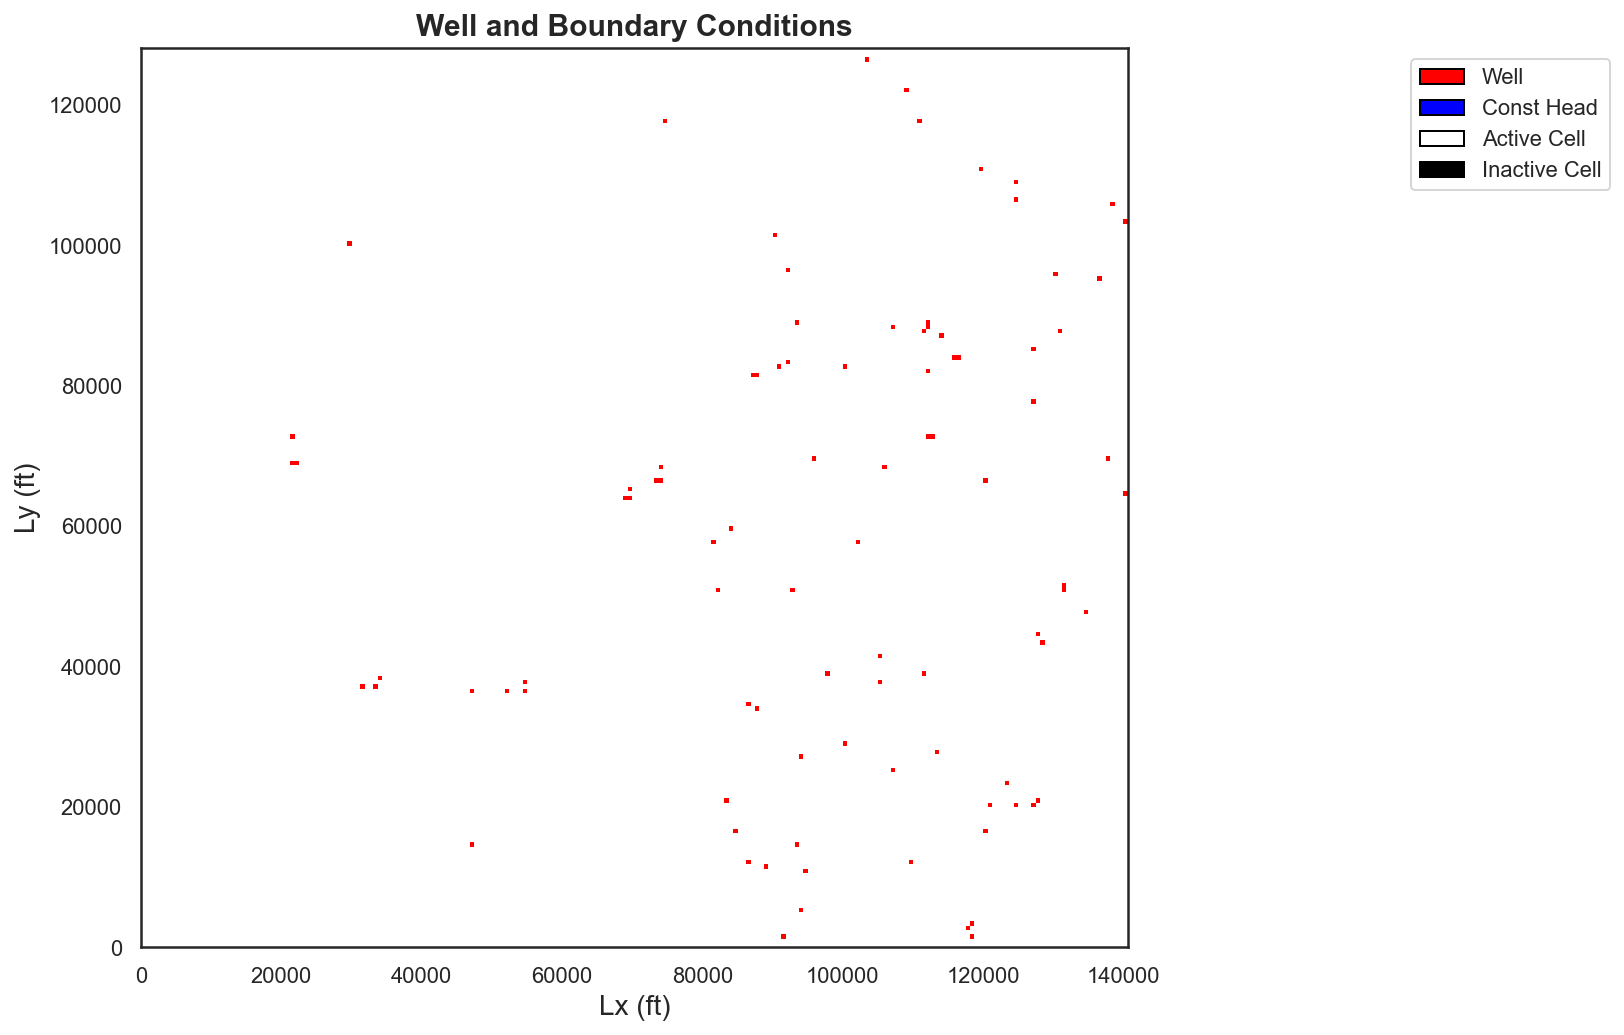

In [34]:
#CHECK WELL LOCATION
#use flopy to plot grid, ibound, and wells
modelmap = flopy.plot.PlotMapView(model=m, layer=0)
# grid = modelmap.plot_grid()
ib = modelmap.plot_ibound()
wel = modelmap.plot_bc(ftype='WEL')
#add labels and legend
plt.xlabel('Lx (ft)',fontsize = 14)
plt.ylabel('Ly (ft)',fontsize = 14)
plt.title('Well and Boundary Conditions', fontsize = 15, fontweight = 'bold')
plt.legend(handles=[mp.patches.Patch(color='red',label='Well',ec='black'),
                   mp.patches.Patch(color='blue',label='Const Head',ec='black'),
                   mp.patches.Patch(color='white',label='Active Cell',ec='black'),
                   mp.patches.Patch(color='black',label='Inactive Cell',ec='black')],
                   bbox_to_anchor=(1.5,1.0))
plt.show(modelmap)

 <a name="V"></a> 
## V. MODFLOW OC Package

The OC package tells MODFLOW which attributes of the head and flow solutions should be printed and saved for each stress period during the model run. 

### Create Output Control Stress Period Data 
To designate what data to save, we create variable <strong> spd </strong> as a  dictionary of stress period data to be used as an argument for the flopy oc function. This takes the form: 

spd = {(stress period, time step): ['PRINT HEAD', 'PRINT BUDGET', 'SAVE HEAD', 'SAVE DRAWDOWN', 'SAVE IBOUND', 'SAVE BUDGET']} 

<strong> Note </strong> that the list of strings may be modified if you wish to only save some of the data. Here we will choose to record and save budget and head values for our steady-state model with a single stress period/time step as we specified in the 'dis' object.

In [35]:
#create oc stress period data. 
spd = {(0, 0): ['print head', 'print budget', 'save head', 'save budget']}

print("oc stress period data: \n", spd)

oc stress period data: 
 {(0, 0): ['print head', 'print budget', 'save head', 'save budget']}


### Define OC object
We will use <strong>spd</strong> to make the 'oc' flopy object which will later be used to create the MODFLOW OC package.

In [36]:
oc = flopy.modflow.ModflowOc(model=m, stress_period_data=spd, compact=True)

 <a name="VI"></a> 
## VI. MODFLOW PCG Package

Attaching the PCG Package to a MODFLOW model, tells MODFLOW to use the Preconditioned Conjugate Gradient Package to solve the finite difference equation. Seeing as this model is steady-state in a very simple domain, the PCG package should have little trouble solving the parabolic groundwater flow equation with its default settings. However, MODFLOW has numerous other solver packages (Newton-Raphson (NWT), Direct Solver (DE4), Strongly Implicit Procedure (SIP), etc) that may be applicable to other models. Additionally, you may want to tweak the solving criterion depending on your model. If you are interested in the nitty gritty of these methods, the MODFLOW-2005 manual is a good resource: https://pubs.usgs.gov/tm/2005/tm6A16/PDF/TM6A16.pdf. 

Additionally, MODFLOW online describes these solvers: https://water.usgs.gov/ogw/modflow/MODFLOW-2005-Guide/index.html?oc.htm

And Flopy documents its communication with the PCG MODFLOW package:
http://modflowpy.github.io/flopydoc/mfpcg.html


### Define PCG object

Here we will create the flopy pcg object which will be used to create the MODFLOW PCG package.

In [37]:
#pcg = flopy.modflow.ModflowPcg(model=m)
pcg = flopy.modflow.ModflowPcg(model=m,mxiter=100,iter1=50,hclose=0.001,rclose=1,relax=0.98,damp=0.7)

### Define LMT object
Finally, we need to create a linkage package to allow the MODFLOW model to connect to a solute transport model

In [38]:
lmt = flopy.modflow.ModflowLmt(m)


 <a name="VII"></a> 
## VII. Write MODFLOW Input Files

Now that we have created all the flopy class instances for the packages we wish to attach to our model (dis, bas, lpf, oc, and pcg), we can use flopy to write the MODFLOW input files for our MODFLOW executable to read. This is done simply with:

In [39]:
#write MODFLOW input files
m.write_input()

Flopy should have created 6 new files in your working directory that look something like:

<img src="https://i.imgur.com/AjODHeO.png" title="modflow_files" /></a>

The file to pay attention to is the "my_model.nam" file. This file governs which packages will be attached to your MODFLOW file. Inside the name file it will list all the packages to be attached to your model as well as specify that BINARY DATA files that it will write as an output. (my_model.hds, my_model.cbc)

<img src="https://i.imgur.com/8KOHV9T.png" title="nam_file" /></a>

Another file to pay attention to, post run, is the LIST file. This will have additional information on how the packages are attached to your model as well as MODFLOW mass-balance budgets during the model run. 

 <a name="VIII"></a> 
## VIII. Run MODFLOW Model

We can now run the MODFLOW model with the packages specified in the .nam file using the executable specified in the definition of our flopy model 'm':

In [40]:
# Run the model
success, mfoutput = m.run_model(pause=False, report=True)
if not success:
    raise Exception('MODFLOW did not terminate normally.')

FloPy is using the following executable to run the model: .\mf2005.EXE

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.12.00 2/3/2017                        

 Using NAME file: my_model.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2022/05/02 15:38:09

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2022/05/02 15:38:26
 Elapsed run time: 16.742 Seconds

  Normal termination of simulation


If the run was successful, you should have seen a window reporting the run time data. 

 <a name="IX"></a> 
## IX. Read Head/Flow Data

We will now make use of flopy's binary file reader and plotting capabilities to read and display the model output.

### Read Head Data

Head data from the my_model.hds file will be stored as a flopy head object.

In [41]:
#extract binary data from head file as flopy head object
headobj = flopy.utils.binaryfile.HeadFile(modelname+'.hds')

print("flopy head object: \n", headobj)

flopy head object: 


This head object has different attributes that can be extracted from it such as the times used in the model run, head data, databytes and more. For information on how to access these functions see: http://modflowpy.github.io/flopydoc/binaryfile.html

For this model, we will extract the head data after our single stress period (totim=1.0).

In [42]:
#extract head data from head object
head = headobj.get_data(totim=1.0)

In [43]:
head

array([[[920.2436 , 920.1382 , 920.1689 , ..., 770.1584 , 770.1042 ,
         770.1175 ],
        [920.0708 , 919.99146, 920.03314, ..., 770.1666 , 770.1413 ,
         770.17725],
        [919.8265 , 919.75745, 919.7661 , ..., 770.1261 , 770.0953 ,
         770.0999 ],
        ...,
        [844.1644 , 847.0532 , 849.91205, ..., 757.90234, 757.88947,
         757.9181 ],
        [850.4557 , 851.19507, 852.0868 , ..., 758.0102 , 757.9763 ,
         758.02   ],
        [852.4137 , 852.6824 , 852.8188 , ..., 758.07495, 758.055  ,
         758.069  ]],

       [[920.2207 , 920.1152 , 920.146  , ..., 769.992  , 769.9565 ,
         769.9367 ],
        [920.0479 , 919.9685 , 920.01025, ..., 769.9623 , 769.93195,
         769.9171 ],
        [919.8036 , 919.7345 , 919.74316, ..., 769.9123 , 769.888  ,
         769.8786 ],
        ...,
        [844.2351 , 847.06177, 849.8899 , ..., 757.85834, 757.8297 ,
         757.8137 ],
        [850.4338 , 851.17285, 852.06433, ..., 757.9804 , 757.9311 ,
   

### Read Flow Data

Flopy's binary budget data reader will be used to read in the budget data from my_model.cbc as a flopy budget object. (See: http://modflowpy.github.io/flopydoc/binaryfile.html#flopy.utils.binaryfile.CellBudgetFile for more info)

In [44]:
#extract binary data from budget file as flopy budget object
budgobj = flopy.utils.binaryfile.CellBudgetFile(modelname+'.cbc')

print("flopy budget object: \n", budgobj)

flopy budget object: 


We can now extract the data from this by passing a string in the CellBudgetFile function's "text" argument to call which part of the data we want to get. Here we will access the flow data for the right face  and front face of each grid cell and save the data as variables 'frf' and 'fff' which are output as arrays.

In [45]:
frf = budgobj.get_data(text='flow right face', totim=1.0)
fff = budgobj.get_data(text='flow front face', totim=1.0)

print("Flow through Right Face of Grid Cells m^3/d \n", frf,
     "\n Flow through Front Face of Grid Cells m^3/d \n", fff)

Flow through Right Face of Grid Cells m^3/d 
 [array([[[ 2.66527712e-01, -7.77307302e-02,  2.36197785e-02, ...,
          6.44973612e+00, -1.58595967e+00,  0.00000000e+00],
        [ 2.00593293e-01, -1.05346389e-01,  1.12936109e-01, ...,
          3.00747132e+00, -4.26928902e+00,  0.00000000e+00],
        [ 1.74540475e-01, -2.19442304e-02,  1.15048036e-01, ...,
          3.66303968e+00, -5.49212039e-01,  0.00000000e+00],
        ...,
        [-7.30382872e+00, -7.22799253e+00, -3.86576104e+00, ...,
          1.53229070e+00, -3.40729928e+00,  0.00000000e+00],
        [-1.86946273e+00, -2.25455594e+00, -1.60931146e+00, ...,
          4.03147650e+00, -5.19542122e+00,  0.00000000e+00],
        [-6.79173648e-01, -3.44923466e-01,  4.35176611e+00, ...,
          2.36957383e+00, -1.65752089e+00,  0.00000000e+00]],

       [[ 2.66728878e-01, -7.78549910e-02,  2.35675275e-02, ...,
          4.96119934e+02,  2.84199402e+02,  0.00000000e+00],
        [ 2.00732023e-01, -1.05535239e-01,  1.13040887e-

Here, it is good to check if results seem reasonable; for this steady-state model, it makes sense that  we see a constant value in the "Flow Right Face" output array as the higher head on the left side of the model induces flow from left to right. The "Flow Front Face" array, has very small positive and negative values in it, suggesting that there are potential numerical oscillations in our solution. However, these fluctuations are so small that the output may still be appropriate depending on the application/precision we are looking for. 

It is good to look for numerical nuances in modeling practice, but the data is much easier to visualize by plotting with flopy's plotting cababilities. 

 <a name="X"></a> 
## X. Plotting

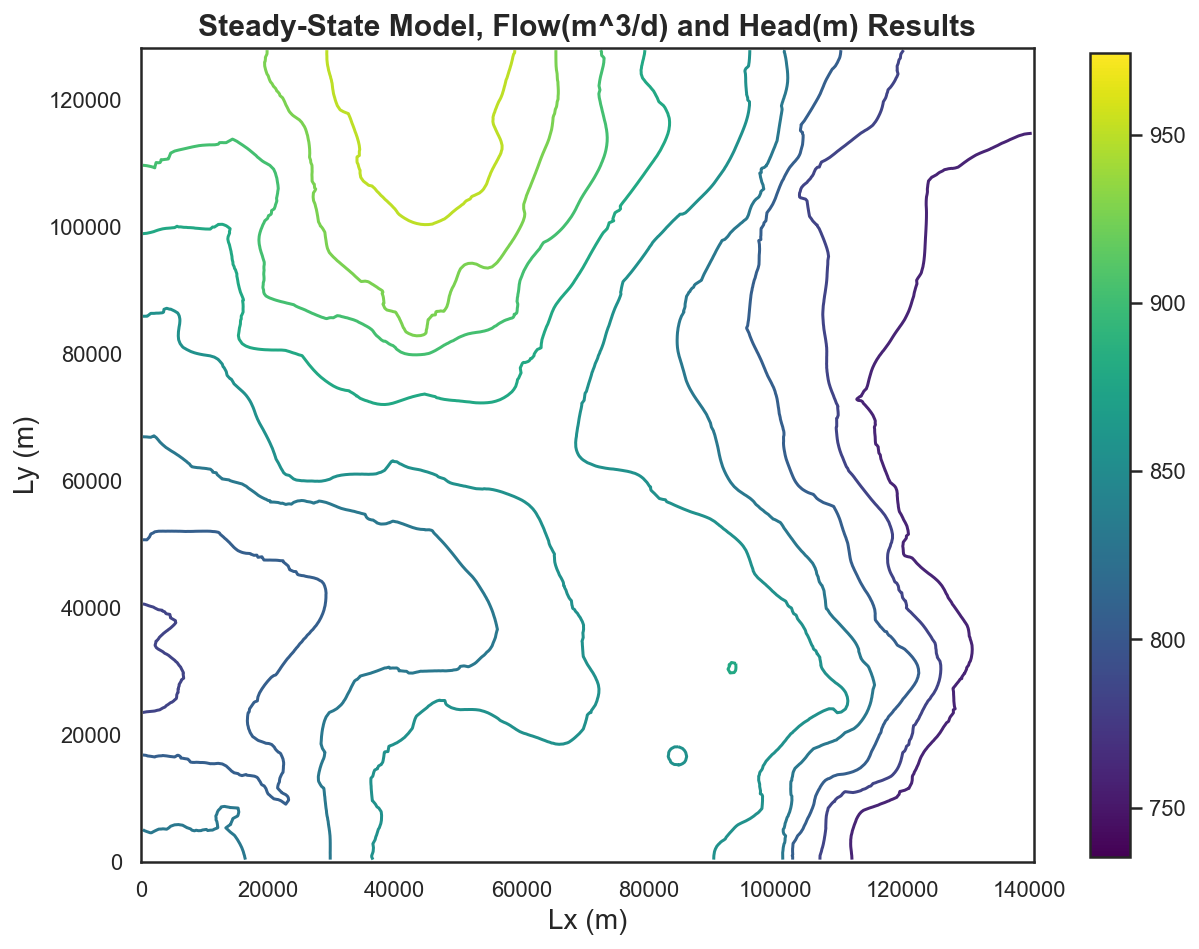

In [46]:
#plot results
plt.figure(figsize=(10,10)) #create 10 x 10 figure
modelmap = flopy.plot.map.PlotMapView(model=m, layer=8) #use modelmap to attach plot to model
#grid = modelmap.plot_grid() #plot model grid
riv_plot = modelmap.plot_bc(ftype='RIV')

contour_levels = np.linspace(head[8].min(),head[8].max(),11) #set contour levels for contouring head
head_contours = modelmap.contour_array(head, levels=contour_levels, cmap = 'viridis') #create head contours
#flows = modelmap.plot_discharge(frf[0], fff[0], head=head) #create discharge arrows

#display parameters
plt.xlabel('Lx (m)',fontsize = 14)
plt.ylabel('Ly (m)',fontsize = 14)
plt.title('Steady-State Model, Flow(m^3/d) and Head(m) Results', fontsize = 15, fontweight = 'bold')

#colorbar
norm = matplotlib.colors.Normalize(vmin=head_contours.cvalues.min(), vmax=head_contours.cvalues.max())
sm = plt.cm.ScalarMappable(norm=norm, cmap = head_contours.cmap)
sm.set_array([])
plt.colorbar(sm, shrink = 0.74)

# plt.colorbar(head_contours,aspect=5)
plt.show(modelmap)

### 3D Surface Plot 

<strong> Note: </strong> This is not part of flopy's plotting, and uses a matplotlib function from a 3d projection toolkit. Flopy takes cell indexing where the top left of the grid is the (0,0) cell index while the Length & Width units start at 0 in the lower left of the grid. This seems a little wierd, but it makes it easy to match up an array of cell by cell numbers to their respective locations on the grid when assigning properties or observing output data. Flopy's plotting functions automatically flip the resultant head data to display on its proper grid, however, for the 3d plots below, you'll see the function np.flipud() is used to flip the data array to plot in the same direction.

C:\Users\Owner\AppData\Local\Temp/ipykernel_2224/2748869716.py:6: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig_3d.gca(projection='3d')


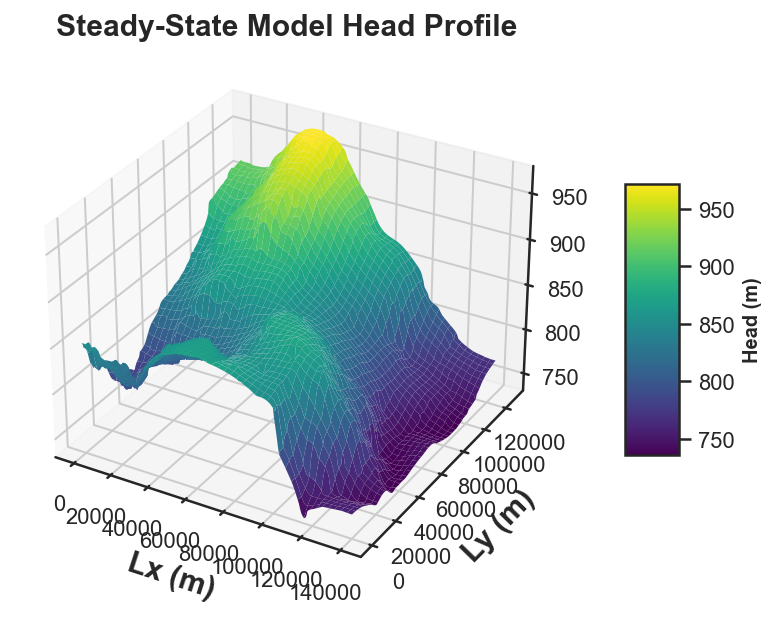

In [47]:
#import 3d axes toolkit from matplotlib
from mpl_toolkits.mplot3d import Axes3D

#create 3d figure
fig_3d = plt.figure(figsize=(12,5))
ax = fig_3d.gca(projection='3d')

#set X, Y, Z variables for 3d plot to be our model domain and head solution
X = np.arange(0,Lx,dx)
Y = np.arange(0,Ly,dy)
X, Y = np.meshgrid(X, Y)
Z = np.flipud(head[8])

#create surface and labels
surf = ax.plot_surface(X,Y,Z, cmap = 'viridis', linewidth=0, label='head')
fig_3d.colorbar(surf,shrink=0.5,aspect=5).set_label('Head (m)',fontsize=10,fontweight='bold')
ax.set_xlabel('Lx (m)', fontsize=15, fontweight='bold')
ax.set_ylabel('Ly (m)', fontsize=15, fontweight='bold')
ax.set_title('Steady-State Model Head Profile', fontsize=15, fontweight='bold')
plt.show(surf)

 <a name="XI"></a> 
 ## XI. Calibration

Now let's import observed heads into a dataframe and compare to observed heads.

Mean Error is 2.747227044753086 feet
Absolute Mean Error is 14.354819968894676 feet


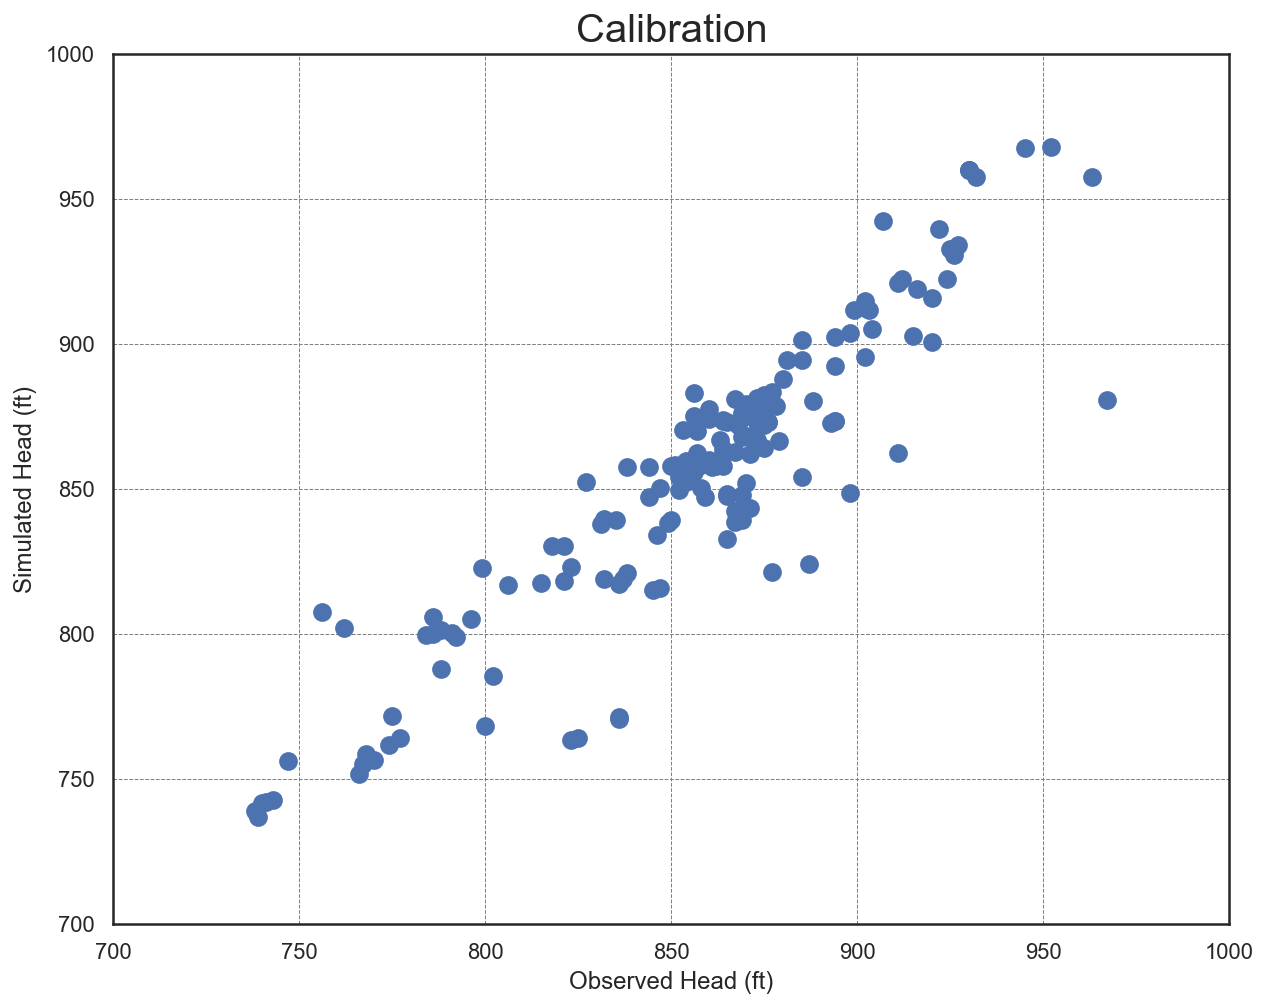

In [48]:
# read ob heads
calheads = pd.read_csv('obheads.csv')
# convert row, column, layer into Python indexing
calheads['row'] = calheads['row']-1
calheads['column'] = calheads['column']-1
calheads['layer'] = calheads['layer']-1
#create an empty list to append simulated heads 
simheads = []
# iterate over the observed heads, pull the corresponding simulated head
for index, values in calheads.iterrows():
    simheads.append(head[values['layer'],values['row'],values['column']])
# add simulated heads to the dataframe              
calheads['sim'] = pd.Series(simheads)
#print(calheads)

#here we can investigate different layers
calheads = calheads[calheads['layer'] >= 2]

# plot simulated vs observed heads
f = plt.figure()
f.set_figwidth(10)
f.set_figheight(8)
plt.scatter(calheads['obhead'],calheads['sim'], s = 70)
plt.grid(color='gray', linestyle='--', linewidth=0.5)
plt.xlim(700, 1000)
plt.ylim(700, 1000)
plt.xlabel('Observed Head (ft)')
plt.ylabel('Simulated Head (ft)')
plt.title('Calibration')

# calculate some basic statistics

# 1. Mean Error
calheads['ME'] = calheads['obhead']-calheads['sim']
print('Mean Error is ' + str(calheads['ME'].mean()) + ' feet')

# 2. Absolute Mean Error
calheads['AME'] = calheads['ME'].abs()
print('Absolute Mean Error is ' + str(calheads['AME'].mean())+ ' feet')


## Calibration results

It is important to keep track of changes you have made and how those changes impacted calibration.

-initial ME=7.79, AME=15.47
-3 Layers ME=6.22, AME=14.97
-4 Layers ME=4.65, AME=14.06

Slow recharge=.0005 ME=3.6, AME=14.27 Probably shifting head above 1-1 line
Slow recharge=.00005ME=6.6, AME=15.12 Probably shifting large head above 1-1 line, walking

Fast recharge=.0005 ME=-23, AME=27.6 Probably shifting head above 1-1 line, walking
Fast recharge = .0008 ME=5.7, AME=14.2
Fast recharge = .0005 ME=9.2, AME=14.7

Horiz conduct x*.5 ME=-3.5, AME=15.9  walking
Horiz conduct x*2 ME=-11.5, AME=16.5  walking, far above 1-1

Vert cond=0.5*z ME=-2.7, AME=14.3
Vert cond=0.25*z ME=-1.9, AME=14.5  above 1-1 line



 <a name="XII"></a> 
 ## XII. MT3DMS
 
In the following code block, we develop run the solute transport modeling code MT3DMS (https://hydro.geo.ua.edu/mt3d/mt3dms2.htm). The packages are discussed in the FloPy documentation here: https://flopy.readthedocs.io/en/3.3.5/code.html. Let's walk through the process of building MT3DMS step-by-step.

First, Let's assign a name for our solute transport model and associated packages. Often, this is the same name as the MODFLOW model, but with *_mt* added at the end

In [49]:
modelname = "my_model_mt"

Next, let's create something that represents our MT3DMS model. In the following code, we assign the name of our MT3DMS model, the executable that we are going to use (it is located in the directory of this ipynb file on GitHub and should be automatically recognized by the code), and the name of the MODFLOW file that will serve the base of this solute transport solution. MT3DMS will actually take the flow simulation from MODFLOW and allow the addition/reaction of contaminants.

In [50]:
mt = flopy.mt3d.Mt3dms(modelname=modelname,exe_name='MT3DMS',modflowmodel=m)


Before moving on, let's do a quick exploration of what kind of file mt is (take a moment to run the code cell below). This is.... a *flopy.mt3d.mt.Mt3dms* data type? We haven't talked about this before, but we are actually now working with object oriented coding. Technically, the above code is not a function, but instead a class definition. When we run the code, we create an instance of this class (I call these instances "objects"). More details on this can be found at: https://docs.python.org/3/tutorial/classes.html. For this project, we don't need to concern ourselves with the precise definitions, but I did want to just give you a brief overview because this is so different than what we worked with earlier in the semester.

In [51]:
type(mt)

flopy.mt3d.mt.Mt3dms

Now, it's time to create another object. This time, we are going to use the Block Transport package class (https://flopy.readthedocs.io/en/3.3.5/source/flopy.mt3d.mtbtn.html). This code defines both model properties and time discretization for the flow solution. In the following code block, we assign the model as *mt*, which is the MT3DMS object that we defined above. We are then adding details by assigning a porosity of 0.3 (this is a value that you may consider changing during calibration). *perlen* defines how long the simulation runs. In our case, we are running from 1950 to 2020, so for 70 years. This is because national road salt applications were estimated to begin in 1950 and are still applied through today. You may consider adjusting the start date of the simulation during your calibration process, although think about whether this is realistic and why you might need to do this. *timeprs* defines which times will be printed (this saves on memory to ensure that the simulated results are not saved for every time step. *dt0* defines the length of time that the simulation will run in the first MT3D time step. *ttsmult* defines a multiplier applied to a time step, and *ttsmax* defines the maximum value of your time step. Feel free to explore how different values change your solution, but be careful, adding too many stress periods can create long run-times.  

In [52]:
# reminder, all time units in the model must be in days
btn = flopy.mt3d.Mt3dBtn(
    model=mt,
    prsity=0.3,
    perlen=70*365, # simulation runs for 70 years
    timprs=[10 * 365, 20*365, 30*365, 40*365, 50 * 365, 60*365, 70 * 365], # times that will be printed in 10 year intervals
    dt0=365, # the first MTD time step will run for 365 days
    ttsmult=1, # often a multipler is applied to each time step; we are not going to do that here, meaning that each time step will be for 365 days
    ttsmax=365, # if we applied a multipler, this would set the max value of a time step
)

Next, we are going to create advection and dispersion objects. I am settling for defaults on these with one exception; I set *mixelm* to 0, which just changes the solution approach (this allows for a smoother, more rapid solution in our example). 

In [53]:
adv = flopy.mt3d.Mt3dAdv(mt,mixelm=0)
dsp = flopy.mt3d.Mt3dDsp(mt)

## Define Chloride Input

In [54]:
# dictionary of k_values for each zones
# this creates a dictionary of values for the x and z zones 

zones_kvalues = pd.read_csv('zones_kvalues.csv', index_col = 0)

# vertical and horizontal sone dictionaries

x_kzones_dict = zones_kvalues.Kx.to_dict() # horizontal K
z_kzones_dict = zones_kvalues.Kz.to_dict() # vertical K

In [55]:
# read in chloride inputs
# All roads shapefile found at => https://gis-idot.opendata.arcgis.com/datasets/IDOT::district-1-roads-2017/about

major_roads = pd.read_csv('Major_roads.csv')
major_roads_municip = pd.read_csv('Major_roads_and_Municipalities.csv')
municip = pd.read_csv('Municipalities.csv')
all_roads = pd.read_csv('All_roads.csv')
all_roads_municip = pd.read_csv('All_roads_and_Municipalities.csv')

In [56]:
# seperate df's by zones

major_roads_zone = major_roads[major_roads.columns[pd.Series(major_roads.columns).str.contains("Z")]]
major_roads_municip_zone = major_roads_municip[major_roads_municip.columns[pd.Series(major_roads_municip.columns).str.contains("Z")]]
municip_zone = municip[municip.columns[pd.Series(municip.columns).str.contains("Z")]]
all_roads_zone = all_roads[all_roads.columns[pd.Series(all_roads.columns).str.contains("Z")]]
all_roads_municip_zone = all_roads_municip[all_roads_municip.columns[pd.Series(all_roads_municip.columns).str.contains("Z")]]

In [57]:
# reshaped chloride inputs

major_roads_zone_reshaped = array_shaper(major_roads_zone,10)
major_roads_municip_zone_reshaped = array_shaper(major_roads_municip_zone,10)
municip_zone_reshaped = array_shaper(municip_zone,10)
all_roads_zone_reshaped = array_shaper(all_roads_zone,10)
all_roads_municip_zone_reshaped = array_shaper(all_roads_municip_zone,10)

In [58]:
# define values for recharge
# here we are using the dictionary and assigning values for the zones
# even zones have high values while odd zones have low values (i.e. high and low permeable areas)

x_kzones_dict[73] = 0.005
x_kzones_dict[74] = 0.01

x_kzones_dict[75] = 400 # made up value for zone 75 because I did not know what to put
x_kzones_dict[76] = 400 # made up high chloride value 

# x_kzones_dict[75] = 1.75 # low chlorire for only municipality
# x_kzones_dict[76] = 5.36 # high chlorire for only municipality

# x_kzones_dict[75] = 1.75 # low chlorire for roads and municipality
# x_kzones_dict[76] = 5.36 # high chlorire for roads and municipality

# choose which chloride input you want in the model........HERE (i.e. all_roads_zone_reshaped)

x_chlor_recharge = np.vectorize(x_kzones_dict.__getitem__)(all_roads_zone_reshaped[0,:,:]) # assign actual chloride values instead of zones

How are we going to add chloride into our model? For this, we need to define the "source and sink mixing class". Most importantly, this is how we are going to add chloride input into our model via recharge. You are going to experiment with this, but briefly, "crch" requires an array of chloride concentrations in recharge. Here we assign a ubiquitous 100 mg/L. Your task will be to add something more realistic based on road networks.  

In [59]:
crch1 = x_chlor_recharge  # 100*np.ones((nrow, ncol), dtype=float) # concentration in the recharge
ssm = flopy.mt3d.Mt3dSsm(mt, crch=crch1)

The rest of this code defines the solver settings with GCG package (let's use defaults), writes the model runs, runs those files, and saves the chloride as an object from the binary "ucn" package. From this object, we can extract the times and concentration arrays associated with this data.

In [60]:
gcg = flopy.mt3d.Mt3dGcg(mt)
mt.write_input()
mt.run_model()
fname = "MT3D001.UCN"
ucnobj = flopy.utils.UcnFile(fname)
times = ucnobj.get_times()
conc = ucnobj.get_alldata()


FloPy is using the following executable to run the model: .\MT3DMS.EXE
 MT3DMS - Modular 3-D Multi-Species Transport Model [Version 5.30]
 Developed at University of Alabama for U.S. Department of Defense

 Using NAME File: my_model_mt.nam                                   

 STRESS PERIOD NO.    1

 TIME STEP NO.    1
 FROM TIME =   0.0000     TO    25550.    

 Transport Step:    1   Step Size:   365.0     Total Elapsed Time:   365.00    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =   218.7      [K,I,J]    1  128  213
 Outer Iter.  1  Inner Iter.  2:  Max. DC =   66.46      [K,I,J]    1  180  192
 Outer Iter.  1  Inner Iter.  3:  Max. DC =   14.04      [K,I,J]    1  120  194
 Outer Iter.  1  Inner Iter.  4:  Max. DC =   23.70      [K,I,J]    3   46   27
 Outer Iter.  1  Inner Iter.  5:  Max. DC =   29.58      [K,I,J]    3   46   27
 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.6125      [K,I,J]    3   46   27
 Outer Iter.  1  Inner Iter.  7:  Max. DC =  0.1715      [K,I,J]    3   46 

 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.2420E-01  [K,I,J]    3  174   61
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.1716E-03  [K,I,J]    1  176  171
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.2062E-03  [K,I,J]    1  176  171
 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.3387E-04  [K,I,J]    1  176  171
 Outer Iter.  1  Inner Iter.  7:  Max. DC =  0.6378E-05  [K,I,J]    3  203   47
 Transport Step:   12   Step Size:   365.0     Total Elapsed Time:   4380.0    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.6532E-01  [K,I,J]    5  197   41
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.7354E-03  [K,I,J]    1  176  171
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.3990E-02  [K,I,J]    3  174   61
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.3020E-03  [K,I,J]    1  176  171
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.1761E-03  [K,I,J]    1  176  171
 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.6805E-04  [K,I,J]    1  176  171
 Outer Iter.  1  Inner Iter.  7:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.3073E-01  [K,I,J]    5   96   17
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1665E-02  [K,I,J]    1  176  171
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.5168E-03  [K,I,J]    1  176  171
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.3659E-03  [K,I,J]    1   57   27
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.8857E-04  [K,I,J]    1  176  171
 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.8747E-05  [K,I,J]    1  106  149
 Transport Step:   25   Step Size:   365.0     Total Elapsed Time:   9125.0    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.2942E-01  [K,I,J]    5   96   17
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1608E-02  [K,I,J]    1  176  171
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.5037E-03  [K,I,J]    1  176  171
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.3543E-03  [K,I,J]    1   57   27
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.8628E-04  [K,I,J]    1  176  171
 Outer Iter.  1  Inner Iter.  6:  Max. D

 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1477E-01  [K,I,J]    5  119   23
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1032E-02  [K,I,J]    1  176  171
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1516E-03  [K,I,J]    1  106  149
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.3174E-03  [K,I,J]    1  106  149
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.5371E-04  [K,I,J]    1  106  149
 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.5677E-05  [K,I,J]    1  106  149
 Transport Step:   40   Step Size:   365.0     Total Elapsed Time:   14600.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1429E-01  [K,I,J]    5  119   23
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.1016E-02  [K,I,J]    1  107  148
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.1136E-03  [K,I,J]    1  106  149
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.3324E-03  [K,I,J]    1  106  149
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.5054E-04  [K,I,J]    1  106  149
 Outer Iter.  1  Inner Iter.  6:  Max. D

 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.8166E-05  [K,I,J]    1  106  149
 Transport Step:   55   Step Size:   365.0     Total Elapsed Time:   20075.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.1005E-01  [K,I,J]    4  176   14
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6815E-03  [K,I,J]    1  107  148
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.4402E-03  [K,I,J]    1  106  149
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.1536E-03  [K,I,J]    1  106  149
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.1831E-04  [K,I,J]    1  106  149
 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.3681E-05  [K,I,J]    1  106  149
 Transport Step:   56   Step Size:   365.0     Total Elapsed Time:   20440.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.9827E-02  [K,I,J]    4  176   14
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.6573E-03  [K,I,J]    1  107  148
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.4270E-03  [K,I,J]    1  106  149
 Outer Iter.  1  Inner Iter.  4:  Max. D

 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.7771E-05  [K,I,J]    1  106  149
 Transport Step:   69   Step Size:   365.0     Total Elapsed Time:   25185.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.8066E-02  [K,I,J]    4  205  211
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.3653E-03  [K,I,J]    1  106  149
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.2829E-03  [K,I,J]    1  106  149
 Outer Iter.  1  Inner Iter.  4:  Max. DC =  0.5455E-04  [K,I,J]    1  106  149
 Outer Iter.  1  Inner Iter.  5:  Max. DC =  0.1097E-04  [K,I,J]    1  106  149
 Outer Iter.  1  Inner Iter.  6:  Max. DC =  0.7674E-05  [K,I,J]    1  106  149
 Transport Step:   70   Step Size:   365.0     Total Elapsed Time:   25550.    
 Outer Iter.  1  Inner Iter.  1:  Max. DC =  0.8037E-02  [K,I,J]    4  205  211
 Outer Iter.  1  Inner Iter.  2:  Max. DC =  0.3441E-03  [K,I,J]    1  106  149
 Outer Iter.  1  Inner Iter.  3:  Max. DC =  0.2763E-03  [K,I,J]    1  106  149
 Outer Iter.  1  Inner Iter.  4:  Max. D

Our concentration data is a 4D array. The first array is the time dimension and has seven entries for the example problem (this may change as your code evolves). The entries are the times that are specified when defining the btn class. The remaining entries are layer, row, and column, respectively.

In [61]:
times

[3650.0, 7300.0, 10950.0, 14600.0, 18250.0, 21900.0, 25550.0]

In [62]:
#start of simulation, 10 years, 50 years, 70 year
np.shape(conc)

(7, 10, 205, 225)

## Chloride Calibration
## Now let's import observed chlorides into a dataframe and compare to observed heads.

Mean Error is 2.0950001318729847 ppm
Absolute Mean Error is 12.440579975896037 ppm


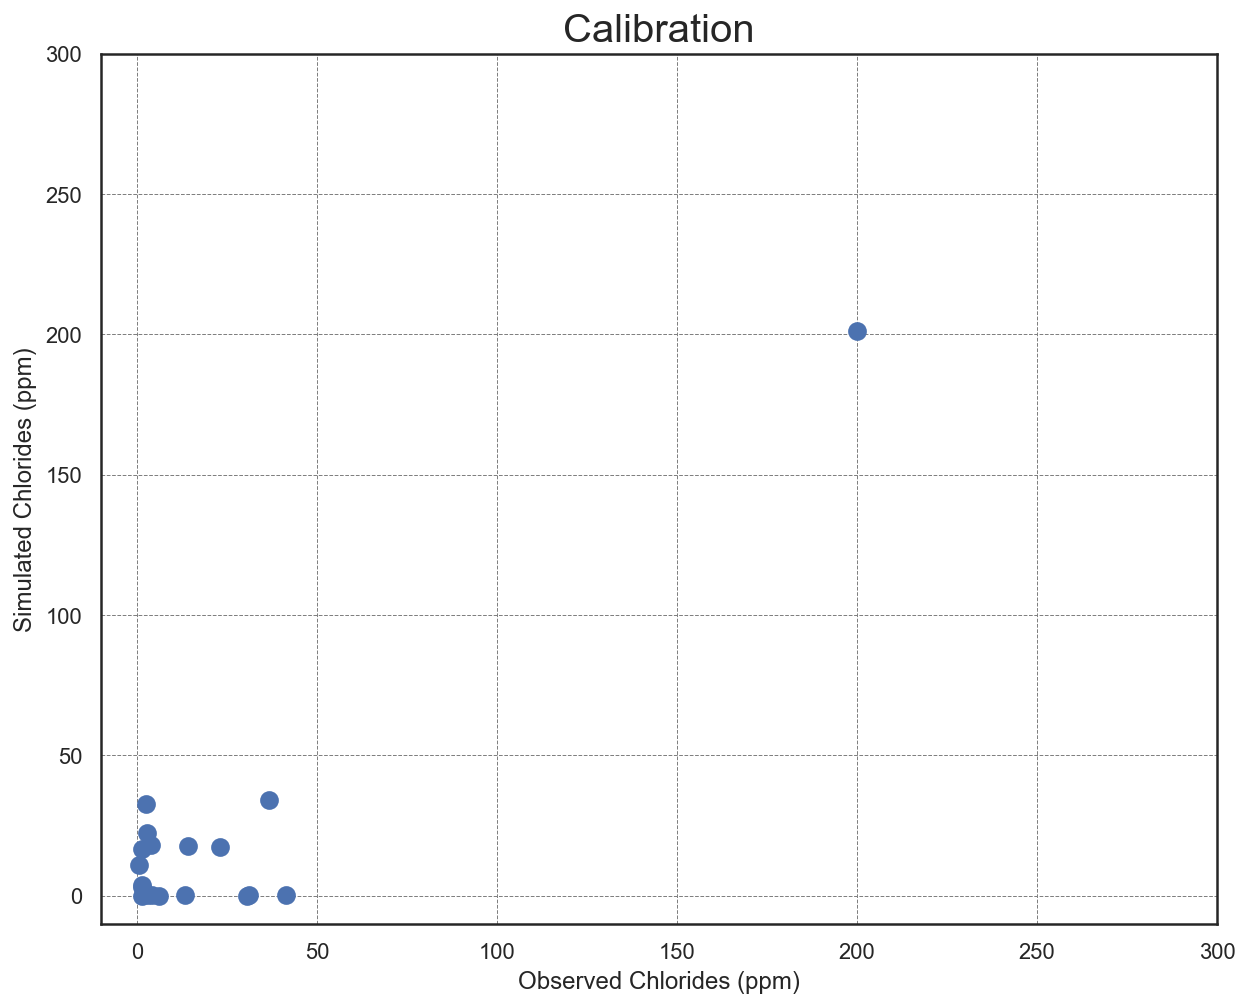

In [90]:
calchlorides=[]
# read observed 2010 chlorides
calchlorides = pd.read_csv('obchlorides.csv')

# convert row, column, layer into Python indexing
calchlorides['row'] = calchlorides['row']-1
calchlorides['column'] = calchlorides['column']-1
calchlorides['layer'] = calchlorides['layer']-1
calchlorides['ppmchloride'] = calchlorides['ppmchloride']

calchlorides
#create an empty list to append simulated heads 
simchlorides = []
# iterate over the observed chlorides, pull the corresponding simulated chloride
for index, values in calchlorides.iterrows():
    simchlorides.append(conc[6,int(values['layer']),int(values['row']),int(values['column'])])

# add simulated chlorides to the dataframe              
# *********************************************
calchlorides['sim'] = pd.Series(simchlorides)
# ***********************************************
#print(calchlorides)
#here we can investigate different layers
calchlorides = calchlorides[calchlorides['layer'] >= 0]

# plot simulated vs observed heads
f = plt.figure()
f.set_figwidth(10)
f.set_figheight(8)
plt.scatter(calchlorides['ppmchloride'],calchlorides['sim'], s = 70)
plt.grid(color='gray', linestyle='--', linewidth=0.5)
plt.xlim(-10, 300)
plt.ylim(-10, 300)
plt.xlabel('Observed Chlorides (ppm)')
plt.ylabel('Simulated Chlorides (ppm)')
plt.title('Calibration')

# calculate some basic statistics

# 1. Mean Error
calchlorides['ME'] = calchlorides['ppmchloride']-calchlorides['sim']
print('Mean Error is ' + str(calchlorides['ME'].mean()) + ' ppm')

# 2. Absolute Mean Error
calchlorides['AME'] = calchlorides['ME'].abs()
print('Absolute Mean Error is ' + str(calchlorides['AME'].mean())+ ' ppm')


,row,column,layer,ppmchloride,sim,ME,AME
0,185,34,1,200.00,2.012206e+02,-1.220612,1.220612
1,180,105,4,14.10,1.750080e+01,-3.400805,3.400805
2,180,147,5,6.06,3.234647e-03,6.056765,6.056765
3,176,166,4,41.40,2.659184e-01,41.134082,41.134082
4,161,62,6,1.34,1.660609e+01,-15.266091,15.266091
5,158,102,6,30.40,1.596754e-06,30.399998,30.399998
6,141,4,2,31.00,2.873552e-01,30.712645,30.712645
7,136,204,8,2.70,2.242753e+01,-19.727526,19.727526
8,131,83,4,4.10,1.028006e-01,3.997199,3.997199
9,127,40,7,1.31,3.049487e+00,-1.739487,1.739487


## Chloride Calculation Results

1.




Finally, we plot the chloride for the specified time and layer. In the below example, we plot "conc[3,8,:,:]", which is the concentration at 40 years, in Layer 9 (8 with Python indexing) which represents the basal sands overlying the bedrock, all rows and columns.

In [ ]:
# we are using the all roads chloride input
# top layer

t_map = 0
plt.figure()
sns.heatmap(conc[t_map,1,:,:], cmap = 'Reds') # 8 is the basal sand that we need to look at
plt.xlabel("DISTANCE ALONG X-AXIS, IN FEET")
plt.ylabel("DISTANCE ALONG Y-AXIS, IN FEET")
plt.title(str(int(times[t_map]/365))+ " years, Glasford aquifer")

In [ ]:
# basal sand layer

t_map = 6
plt.figure()
sns.heatmap(conc[t_map,8,:,:], cmap = 'Reds') # 8 is the basal sand that we need to look at
plt.xlabel("DISTANCE ALONG X-AXIS, IN FEET")
plt.ylabel("DISTANCE ALONG Y-AXIS, IN FEET")
plt.title(str(int(times[t_map]/365))+ " years, Glasford aquifer")

## Chloride Data Calibration - Annie and Geoff